# Satellite Remote Sensing

Ever seen a spy movie where they zoom all the way from orbit in to read a newspaper over someone's shoulder?  
We won't be doing that today (or probably ever; atmospheric distortions are severe at that scale).

Instead, we're going to look at larger images that can tell us about the environment.  
More specifically, we're going to look at some [vegetation indices](https://en.wikipedia.org/wiki/Vegetation_Index) - hopefully you remember these from your reading!
Understanding vegetation properties and and how they change over time is especially important in Australia, where what vegetation we *do* have is prone to both drought and fire.

Our goals for today:

1. We'll start by opening and viewing an image of ANU, and check that the data makes sense.
2. Then, I'll give a worked example of calculating [NDVI, the normalised difference vegetation index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index), which we can use to investigate the ANU playing fields.
3. After that, you'll look at a time-series of images from before, during, and after one of the Black Saturday bushfires.
   Analysing vegetation change can help us understand what happened in this location.
   
## Part 1: loading the ANU data

In [4]:
# As usual, we start with our standard imports
import numpy as np
import pandas as pd
import matplotlib as plt

# And for remote sensing, we add Xarray - it's inspired by Pandas, and designed
# to handle groups of multi-dimensional arrays.  See http://xarray.pydata.org/
import xarray as xr

# Finally, we'll use a "magic" - that's the official name - to show plots inline.
%matplotlib inline
# (starting with `%` is invalid syntax in Python, so IPython and Jupyter use
#  it to denote special commands that change e.g. how they render plots for us)

In [5]:
# We'll start by looking at an aerial photo of ANU, taken in 2014.
# This is just a few bands from a hyperspectral survey.
da = xr.open_dataarray("anu_array.nc")
# Conventional name for a DataArray is "da", to match pd.DataFrame -> "df" and xr.DataSet -> "ds".
# Interesting aspects of this array: the band dimension has coordinates, but x and y don't!
da

<xarray.DataArray 'brightness' (x: 482, y: 521, band: 4)>
[1004488 values with dtype=int16]
Coordinates:
  * band     (band) object 'red' 'nir' 'green' 'blue'
Dimensions without coordinates: x, y

(array([6.92685e+05, 1.81287e+05, 1.07271e+05, 2.17250e+04, 1.46700e+03,
        3.00000e+00, 2.90000e+01, 1.10000e+01, 0.00000e+00, 1.00000e+01]),
 array([  -22. ,  1302.8,  2627.6,  3952.4,  5277.2,  6602. ,  7926.8,
         9251.6, 10576.4, 11901.2, 13226. ]),
 <a list of 10 Patch objects>)

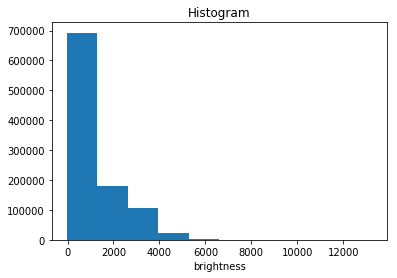

In [6]:
# Lets see what the default plot looks like:
da.plot()

This is the default plot type for multi-dimensional arrays of data: a [histogram](https://en.wikipedia.org/wiki/Histogram) of value counts.  We can see that dark pixels are most common, but don't know anything about the spatial or spectral structure of the image.  If I didn't know, I'd bet that this isn't an image of snow, ice, or a salt pan - all of which are bright white - but beyond that it's hard to tell.

To make other kind of plots, we need to select a subset of the data, and plot that.  We'll get a line plot for 1D data, or an image for 2D.

(you can read [the Xarray plotting docs](http://xarray.pydata.org/en/stable/plotting.html) for more options, but we'll stick to the defaults for now)

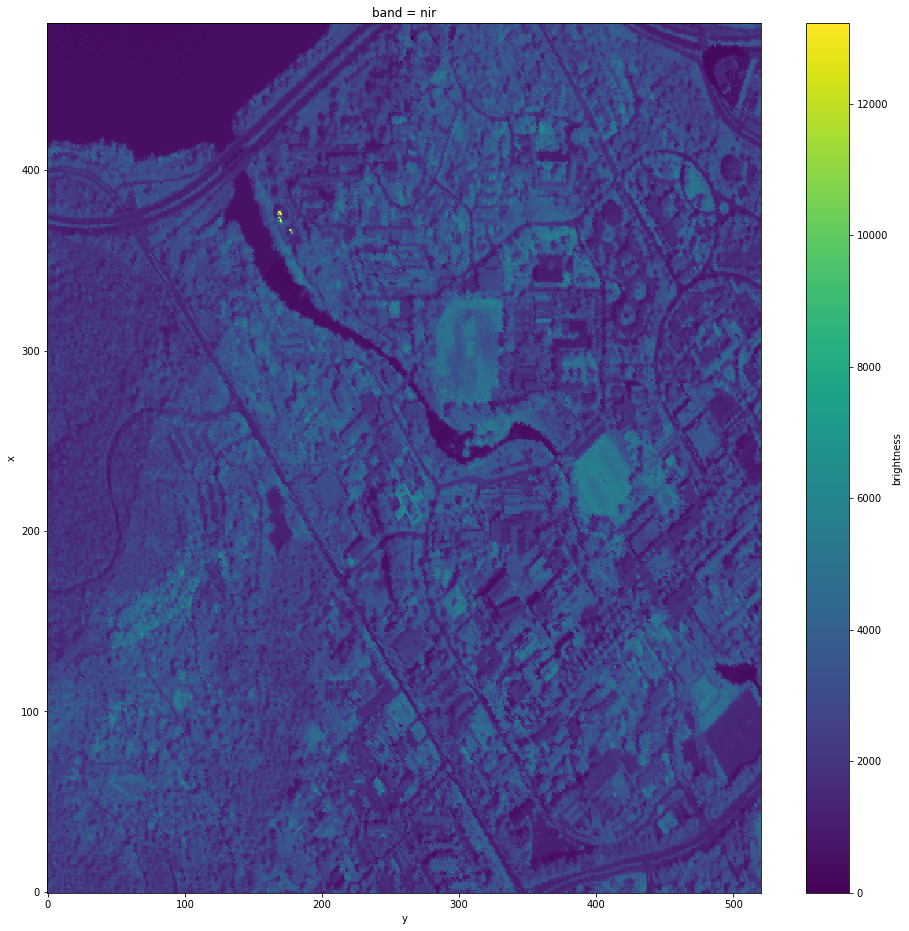

In [17]:
# We can select a single step in the "band" dimension by name using the `.sel` method, because it has coordinates.
# For x and y, we would need to use `.isel` with a normal index.
# Try adding `.isel(x=220)` before the `.plot()` call - what does this show?
da.sel(band="nir").plot(figsize=(16,16))

Now, let's select particular areas of the dataset in `(x, y)` space.  
We can plot these as images again, or draw another histogram!

I've drawn one for the lake (top-left) below - try selecting one of the playing fields or built-up areas.

(array([5.709e+04, 8.596e+03, 2.380e+03, 1.654e+03, 1.772e+03, 1.869e+03,
        7.120e+02, 2.200e+02, 7.400e+01, 3.300e+01]),
 array([ -22.,  544., 1110., 1676., 2242., 2808., 3374., 3940., 4506.,
        5072., 5638.]),
 <a list of 10 Patch objects>)

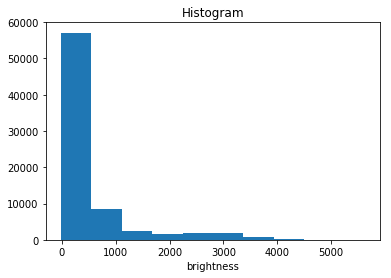

In [26]:
# A `slice` describes a selection with a start, stop, and step value. 
# See https://docs.python.org/3/library/functions.html#slice
lake = da.isel(x=slice(420, 800), y=slice(0, 300))
# ...and plot it as a histogram.
lake.plot()

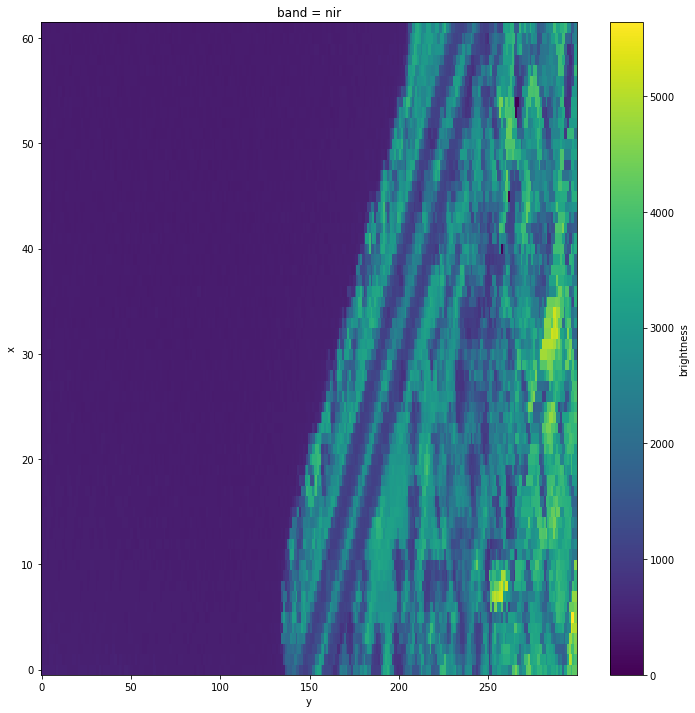

In [27]:
# If we plot it as an image, note the x- and y-tick labels.  No coordinates!
# The scale of the colorbar is also different; more on this in a minute.
lake.sel(band="nir").plot(figsize=(12,12))

Now, let's use the `col` and `col_wrap` argument to make a faceted plot, where we can see all the bands:

**Sensebook question:** How does the choice of bands and the extent of the colormap affect your use or interpretation of this plot?  
*(you might want to keep going and come back to this one)*

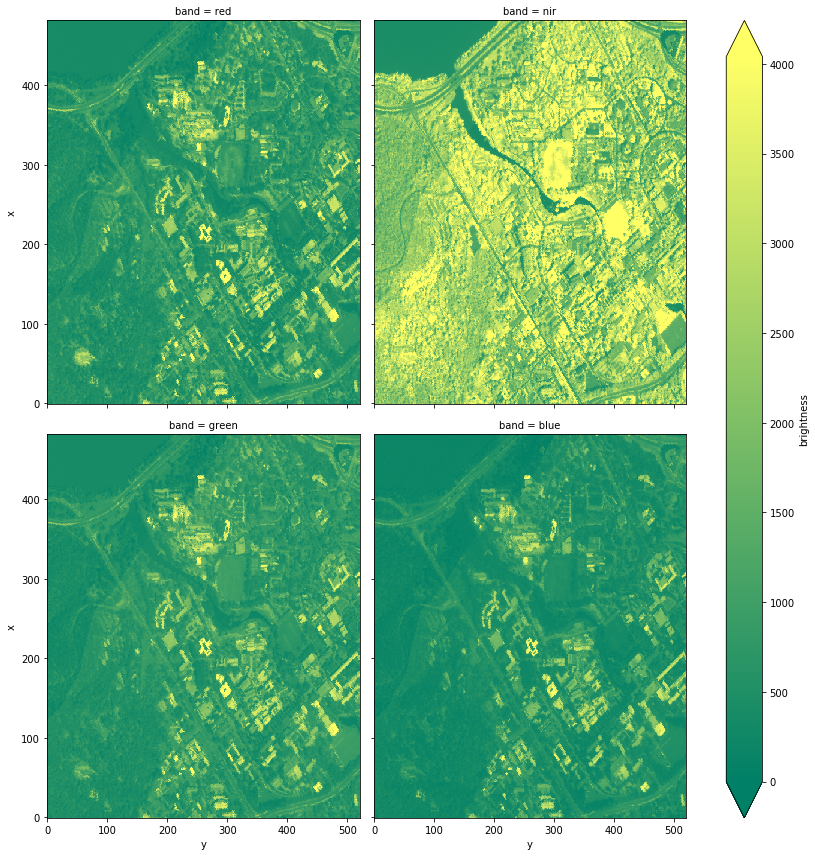

In [42]:
# Here, we use the `robust=True` argument to automatically set the extent 
# of the colormap between the 2nd and 98th percentiles of the data.
# You can use `vmin` and `vmax` to set exact limits as well or instead.
da.plot(col="band", col_wrap=2, vmin=0,robust=True,figsize=(12,12),cmap=plt.cm.summer)

So ANU seems much brighter in the near-infrared band than in visible light!  (is this unexpected, or reasonable?)

However, clipping the range of values like this means we can't tell if the bright spot (around x=380, y=180) in our image of the blue channel is also present in other bands.  Start by checking [google maps](https://www.google.com/maps/@-35.2805204,149.1184457,2313m/data=!3m1!1e3), and form a hypothesis.  What do you think this might be, and do you expect it to be bright or dark in other bands?

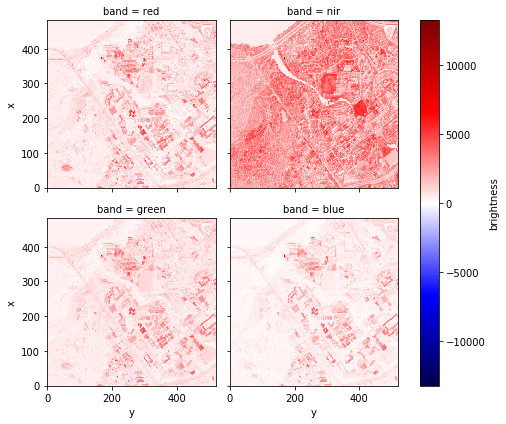

In [44]:
da.plot(col="band", col_wrap=2, cmap=plt.cm.seismic)

What.  There's a bright dot in all the bands, but the whole display is different!

Xarray has given us a *diverging* colormap, which means there must be some negative numbers in this dataset.  But each number is - or should be - an amount of light that reached the sensor, and therefore negative values should be impossible.

How could this have happened?  **Have a conversation** with someone close to you, then interview Zac (acting as data provider).

Once you're done let's investigate the "weird pixels" quickly.

In [45]:
# Taking the minimum along the x and y dimensions leaves us with a 
# one-dimensional array - the minimum value for each band. 
da.min(dim=("x", "y"))

<xarray.DataArray 'brightness' (band: 4)>
array([  0,   0,   0, -22], dtype=int16)
Coordinates:
  * band     (band) object 'red' 'nir' 'green' 'blue'

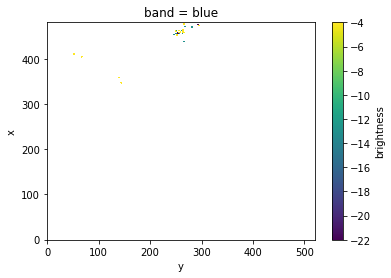

In [46]:
# Hmm.  We'll try selecting only the negative numbers, 
da.where(da < 0).sel(band="blue").plot()

There are only a few, so it doesn't look too important - another case for human judgement.  We have two choices here:

- just clip negative numbers to zero and move on with our lives (expedient), or
- replace negative numbers with "not a number" and put up with the gaps (principled but inconvenient) 

**Sensebook question:** how else might you respond to weird data corruption, and why or why not?

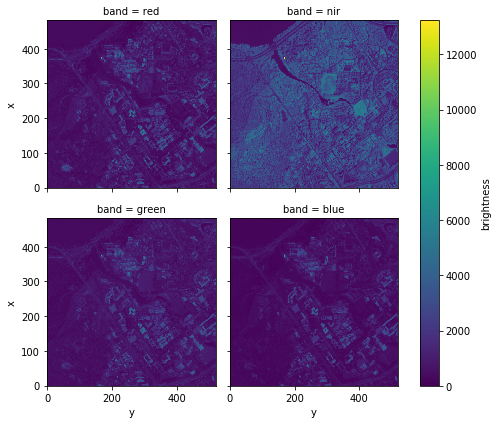

In [59]:
da = da.clip(min=0)
# or, `da = da.where(da >= 0)`

# Ahh, that's much better.
da.plot(col="band", col_wrap=2)

## Part 2: a vegetation index

We've loaded and displayed our data, and we're *reasonably* confident that it's physically meaningful.  We do need to bear in mind that this is *uncorrected brightness* - that is, we know that the sensor recorded a brightness value (close to true brightness, we hope) but do not know the relationship between "amount of light" and "proportion of light diffusely reflected" for each pixel.

The way the data was collected and pre-processed determines what analyses will be meaningful.  Unfortunately there's no way for Python to stop us from precisely calculating a meaningless result; that's still a job for thoughtful humans.

Let's start by investigating ANU's playing fields, as they give us relatively large areas of a single vegetation types to work with.  For this trick, we're on the fact that a ratio index like NDVI is useful with pretty dodgy data, because it's designed to make the errors (from e.g. slope, shadow, solar angle, image angle) cancel out between bands as much as possible.

We'll start by rendering a true-color image for comparison.  Zac wrote this code because true- or false-color RGB images are often useful, but used to be really really annoying to draw; now it's just cryptic.

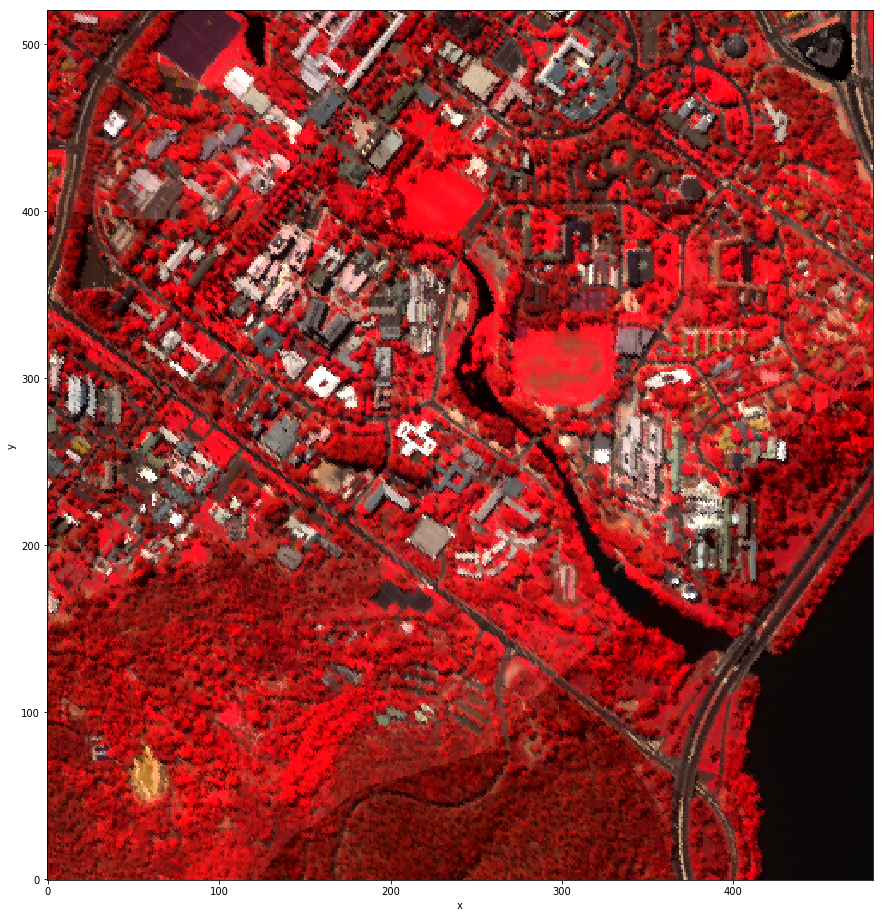

In [70]:
# You do not need to and are not expected to know how this works, just that it does.
dat = da.transpose()
#da.sel(band=["red", "green", "blue"]).plot.imshow(robust=True)
dat.sel(band=["nir", "red", "green"]).plot.imshow(robust=True,figsize=(14.8,16))



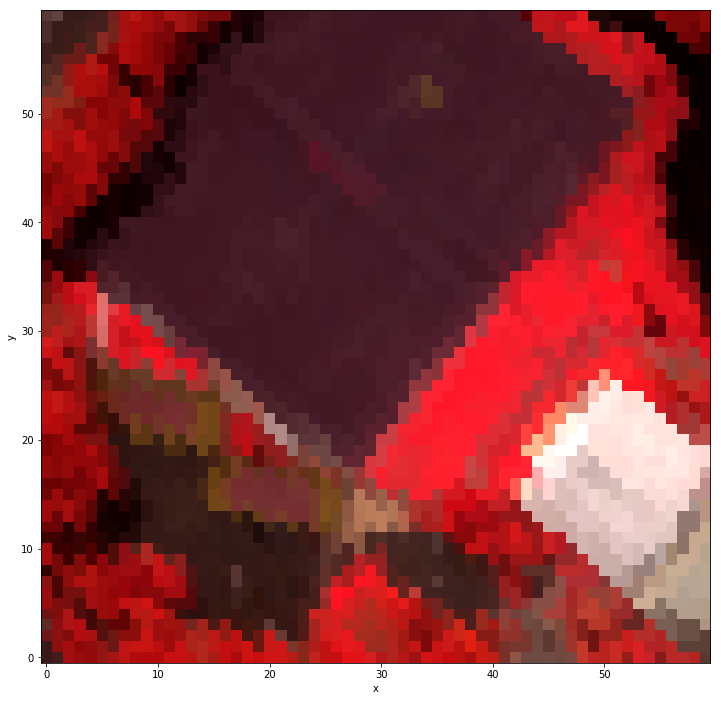

In [86]:
dat.y.size
field1 = dat.isel(x=slice(60, 120), y=slice(461, 521))
field1.sel(band=["nir", "red", "green"]).plot.imshow(robust=True,figsize=(12,12))

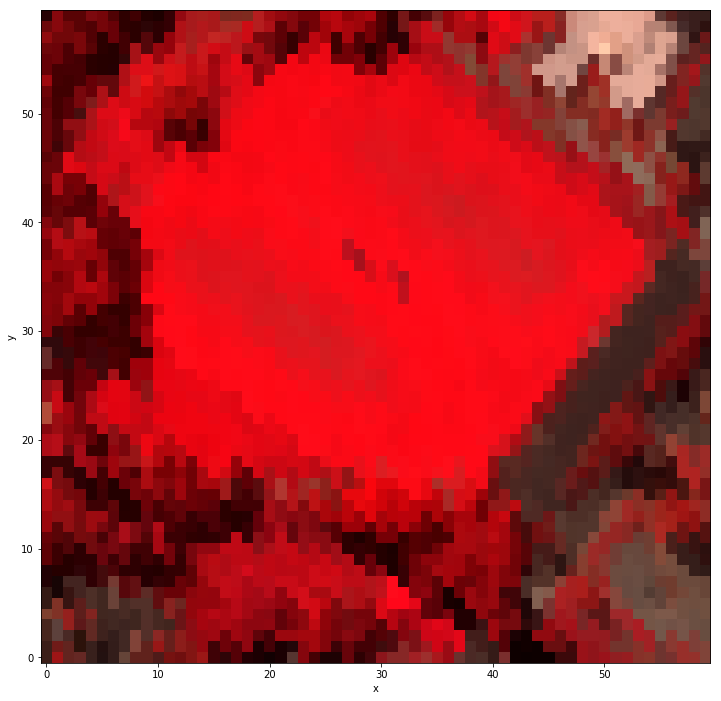

In [85]:
field2 = dat.isel(x=slice(200, 260), y=slice(370, 430))
field2.sel(band=["nir", "red", "green"]).plot.imshow(robust=True,figsize=(12,12))

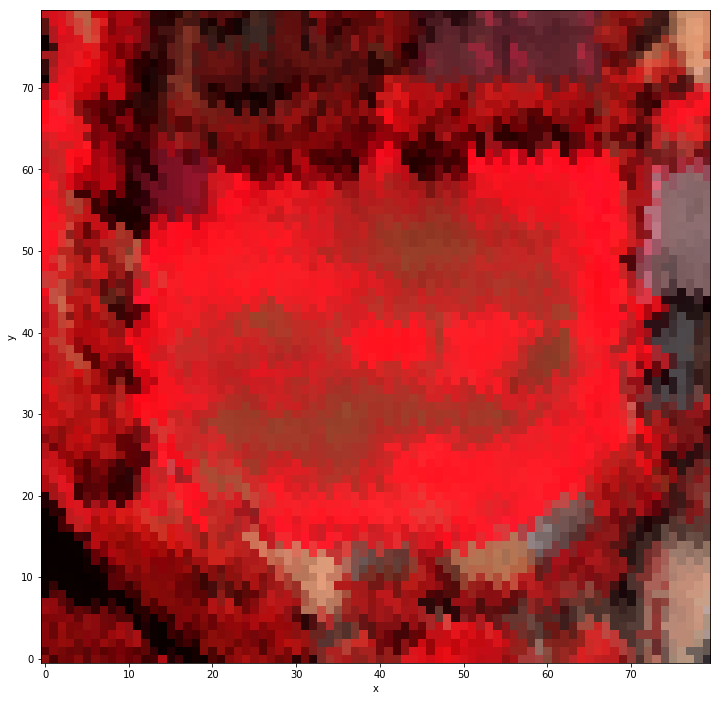

In [89]:
field3 = dat.isel(x=slice(260, 340), y=slice(270, 350))
field3.sel(band=["nir", "red", "green"]).plot.imshow(robust=True,figsize=(12,12))

Can you count the playing fields in this image?  Compare your count and locations with someone else.

*Now* let's calculate the NDVI, and see if that tells us something!  The equation is $NDVI = \frac{nir - red}{nir + red}$, so we'll need to select the `nir` and `red` bands from our array.  Doing arithmetic on arrays in Python operates per-element, so it's really easy when they're the same size!

For example: `array([1, 2, 3]) * array([1, 2, 3]) + array([10, 20, 30])` -> `array([11, 24, 39])`.  
(There are [more complicated rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) for arrays of different shapes or dimensions, which you probably don't need to know)

In [71]:
ndvi = (
      (dat.sel(band="nir") - dat.sel(band="red"))
    / (dat.sel(band="nir") + dat.sel(band="red"))
).rename("NDVI")
ndvi

<xarray.DataArray 'NDVI' (y: 521, x: 482)>
array([[0.610319, 0.580616, 0.578653, ..., 0.04703 , 0.04703 , 0.039191],
       [0.592559, 0.580616, 0.522352, ..., 0.045623, 0.04703 , 0.030451],
       [0.592559, 0.557288, 0.542233, ..., 0.045623, 0.048469, 0.048469],
       ...,
       [0.823596, 0.814108, 0.618121, ..., 0.580497, 0.539191, 0.516404],
       [0.823596, 0.791479, 0.791185, ..., 0.25    , 0.514399, 0.516404],
       [0.803727, 0.791479, 0.573833, ..., 0.25    , 0.554728, 0.528205]])
Dimensions without coordinates: y, x

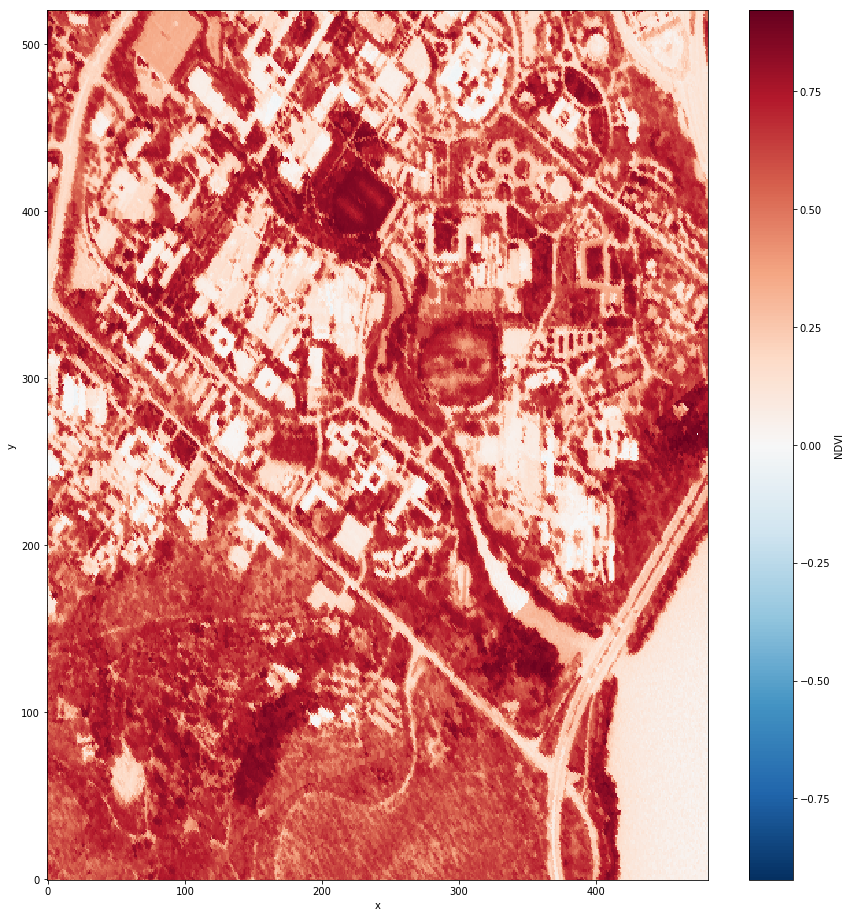

In [73]:
ndvi.plot(figsize=(14.8,16))

And it's another diverging colormap - no matter the values of `red` and `nir`, NDVI is always between $\pm$1.  A decent rule of thumb for interpreting NDVI is that negative values are almost always water, small values are dirt or buildings or dry plants, and values above 0.4 or so are live plants.  In this case, Lake Burley Griffin has enough algae in it to have a positive (probably-not-water) NDVI!

Can you see the playing fields in this image?  Let's try plotting again, excluding outliers from the colormap:

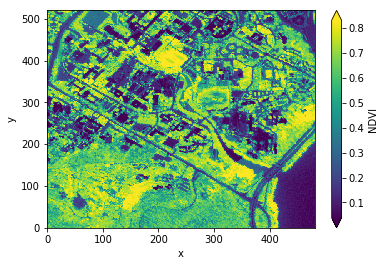

In [74]:
# Is there anything surprising about the fields?  If so, what surprises you and why might it happen?
ndvi.plot(robust=True)

In [ ]:
# Now, it's your turn to select and compare a few playing fields.
# (remember you can insert more cells with the `Insert` menu at the top)


## Part 3: Bushfires!

Now that we've found the fake grass, let's turn to a more serious use-case for vegetation indices: assessing the damage and recovery from a bushfire.

This set of images was taken by [Landsat 5](https://en.wikipedia.org/wiki/Landsat_5), the longest-running earth observation satellite to date.  Because this is a well-known and well-calibrated platform, the data has already been processed to give us several advantages during analysis:

- The effect of the atmosphere and angle of the sun have been eliminated to the greatest degree possible
- Instead of brightness, we can work with "reflectance": the proportion of light scattered by the surface.  That should always be between zero and one!
- Every pixel has a known and exact location in time and space, so we can accurately measure distances.

Let's start by opening this new dataset:

In [75]:
# This data stores each band as a separate variable, like columns in Pandas.
# What advantages might this have?  
ds = xr.open_dataset("bushfire.nc")
ds

<xarray.Dataset>
Dimensions:  (time: 3, x: 988, y: 822)
Coordinates:
  * x        (x) float64 1.144e+06 1.144e+06 1.144e+06 ... 1.243e+06 1.243e+06
  * time     (time) datetime64[ns] 2009-01-31T23:48:57.500000 ... 2009-04-21T23:50:46.500000
  * y        (y) float64 -4.116e+06 -4.116e+06 ... -4.198e+06 -4.198e+06
Data variables:
    blue     (time, y, x) float32 ...
    green    (time, y, x) float32 ...
    red      (time, y, x) float32 ...
    nir      (time, y, x) float32 ...
    swir1    (time, y, x) float32 ...
    swir2    (time, y, x) float32 ...
Attributes:
    geospatial_bounds_crs:  EPSG:4326
    lat_min:                -37.78
    lat_max:                -37.78
    lon_min:                144.93
    lon_max:                145.96

- Every dimension has a coordinate index in this dataset.  The coordinates even have units, though they're not shown in this view - you can check `ds.x` or `ds.y` to see that each pixel is 100m across.  The time-index unit is part of the array dtype, datetime with nanosecond precision, rather than Xarray metadata.
- Our data variables include the visible spectrum (blue, green, red), near-infrared, and two shortwave infrared bands.
  The latter are closely related to temperature, and form a crude measurement of it - investigate in free time if you're interested.
- The dataset also has "Attributes", in this case extra metadata about where the image was taken.  Unfortunately there's been a typo in the latitute metadata, but we could in principle recover that from the x-coordinates (geodesy is *way* out of scope today though)

Now let's do a quick sanity-check by calculating `ds.max()` and `ds.min()`.  What do you see?

In [77]:
# There's an oddity here, which is probably a de-hazing artefact from a smoky image.
# Should we be worried?  You can investigate, and refer to Smith p22, later if you want to.
ds.min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    blue     float32 0.0043945312
    green    float32 0.011047363
    red      float32 0.008605957
    nir      float32 0.013977051
    swir1    float32 -0.06097412
    swir2    float32 -0.06097412

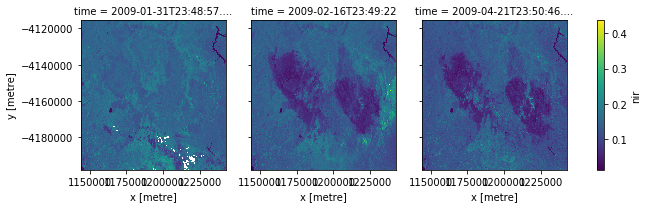

In [78]:
# Instead of using `.sel`, we can access the variables directly - like Pandas again!
ds.nir.plot(col="time")

It's already pretty clear that something changed between the first two timesteps!  
Let's take a quick look at *all* the data...

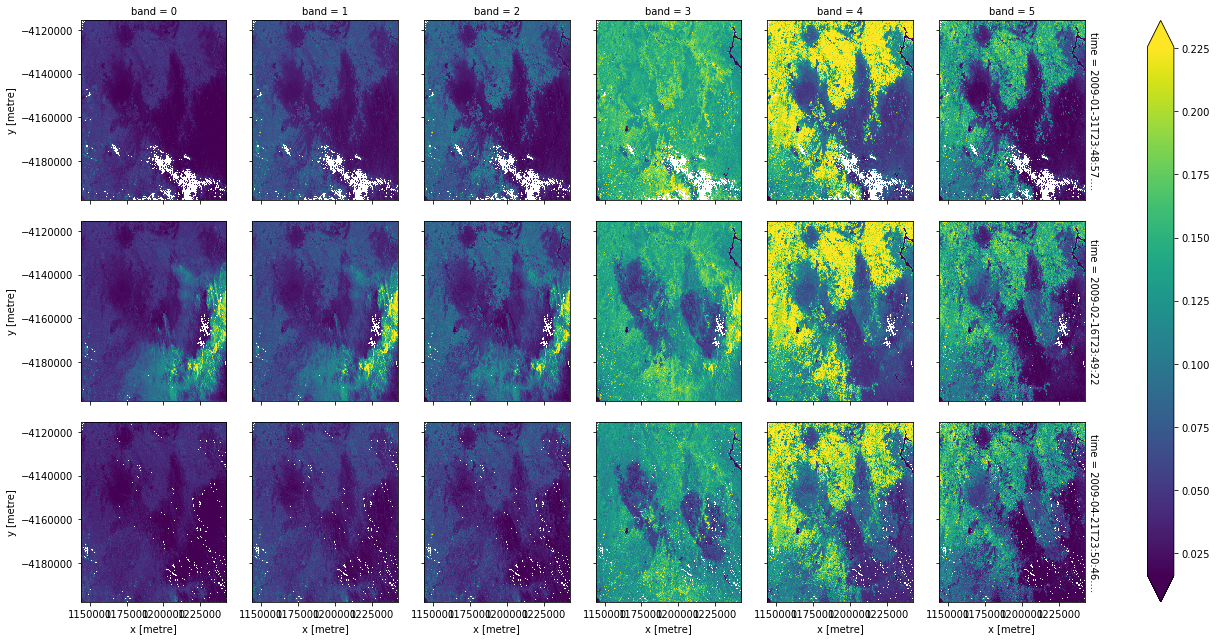

In [79]:
# This is a relatively expensive operation, because we're creating a whole new array
# with all of that data!  It's not too far from here to "big data" tools...
stacked = xr.concat(
    # The arrays to concatenate, and the name of the new dimension
    [ds.blue, ds.green, ds.red, ds.nir, ds.swir1, ds.swir2], dim="band"
)
# But then we plot it the same way, using `.imshow` for speed.
# (ask Zac for more details you don't need if you're interested)
stacked.plot.imshow(row="time", col="band", robust=True)

Informative, right?  Well... maybe not so much.

- The white patches are 'missing data', usually where the land was covered by clouds.  That can make any band-based analysis nonsensical, so they're usually removed in advance by setting those pixels to the special `NaN` (Not a Number) value.
- There's some spatial structure in the image, which seems related to the change in later time steps.  This is probably a difference in vegetation type, but it's not clear what's what.
- The creek in the top-right is clearly visible in `nir` and `swir1` - we can tell it's a creek by the shape, and characteristic low diffuse reflectivity of water in the infrared spectrum (i.e. it's shiny and cold!)
- Otherwise... ¯\\\_(ツ)\_/¯

This is where you get to write some code: fill out the cell below to create a stacked array with red, green, and blue to see a true-color visualisation of the scene.

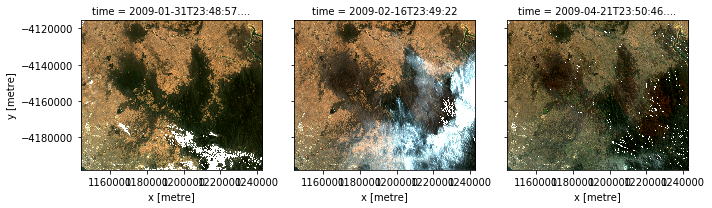

In [92]:
# Hint: you can copy and adjust the `concat` code above.
# If the image doesn't make sense, check the order of the colors!
rgb = xr.concat(
    # The arrays to concatenate, and the name of the new dimension
    [ds.red, ds.green, ds.blue], dim="band"
)
#rgb = rgb.transpose()
# We'll arrange the time axis in left-to-right panels:
rgb.plot.imshow(col="time", robust=True)

Hopefully you can see

- Which areas are dry grass, and which are forest
- The haze and plume of smoke that has *not* been removed, because it wasn't detected as clouds, but will cause similar problems in our analysis.  

*If you want an extension excercise: calculate a boolean "mask" grid which is True for pixels where there is smoke, and False elsewhere.  You can use any combination of bands.  Then create a copy of `ds` with those pixels set to `np.nan`, and do the remaining steps to both.  How do they compare?*

...but it's hard to distinguish dark unburned forest from dark burned forest.  NDVI to the rescue!

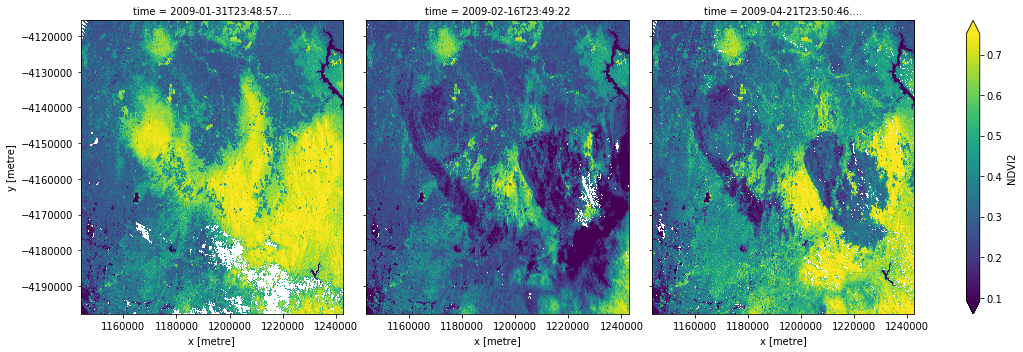

In [102]:
ndvi2 = (
      (ds.nir - ds.red)
    / (ds.nir + ds.red)
).rename("NDVI2")
ndvi2.plot.imshow(col="time", robust=True, figsize=(16,5))
# Plot it here! What happens if you leave out `col="time"`?  Why?

You should be able to see the forest in bright yellow, and grass in shades from dry blue to healthy aqua.
In the second plot facet, the burned area is dark blue - what effect might the smoke have?
In the third facet, some months later, the grass is recovering well due to winter rain but the forested area is still pretty dead.

Let's plot these temporal summaries:

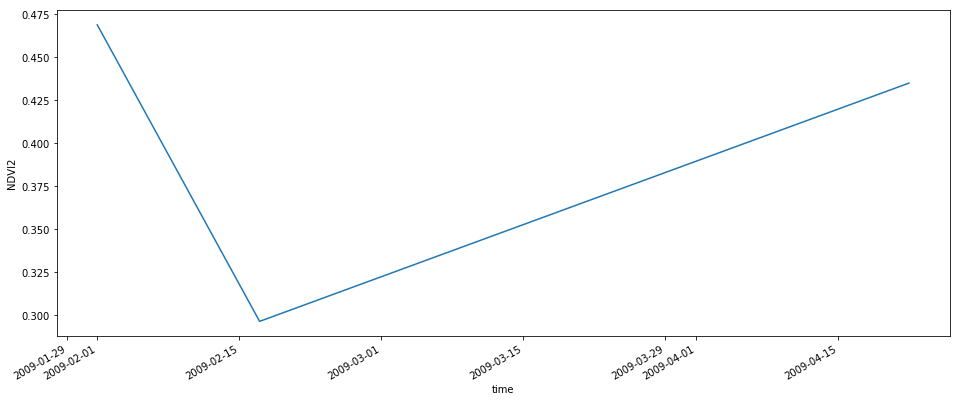

In [127]:
# Take the `.mean` of NDVI along the x and y dimensions, and draw a line plot.

#ndvi2_m = ndvi2.groupby('time.dayofyear').mean()
#ndvi2_m.plot()
ndvi2_m2 = ndvi2.mean(dim=('x','y'))
ndvi2_m2.plot(figsize=(16,6))


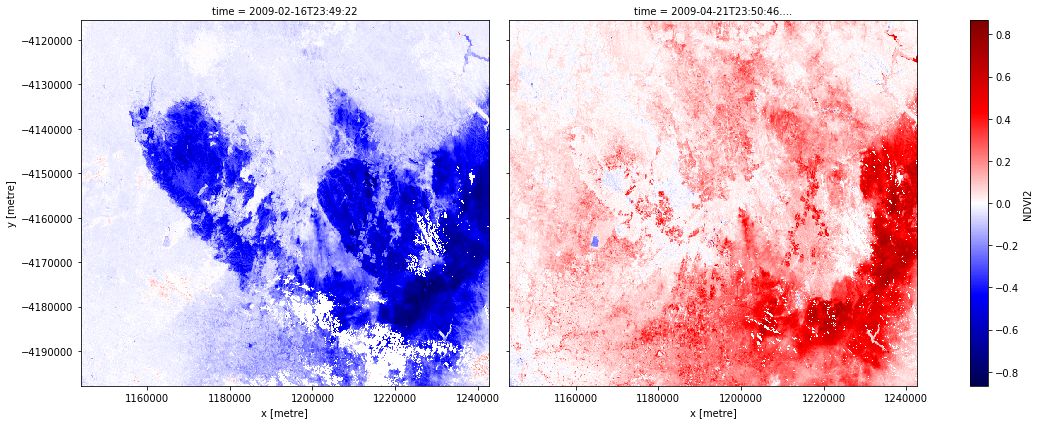

In [136]:
# Take the `.diff` between each time-step of NDVI, to plot the change between each pixel.
# Check `ndvi.diff?` for docs if you need them or consult a peer.
# How much of this effect do you think is really due to the vegetation?
#import datetime
#ndvi2['time.dayofyear']
ndvi_d1 = ndvi2.diff('time')
ndvi_d1.plot.imshow(col='time',figsize=(16,6), cmap=plt.cm.seismic)

3

Finally, let's calculate the [enhanced vegetation index, or EVI](https://en.wikipedia.org/wiki/Enhanced_vegetation_index), and compare it to NDVI.  NDVI works well with very low quality (or even uncorrected) data, but with good data EVI has lower background noise, atmospheric noise, and saturation in most cases.

$EVI = G \cfrac{nir - red}{nir + C1 * red – C2 * blue + L}$


EVI incorporates an `L` value to adjust for canopy background and `C` values as coefficients for atmospheric resistance, which are L=1, C1 = 6, C2 = 7.5, and G = 2.5 (for Landsat as well as MODIS).

In [ ]:
evi = 

In [ ]:
# How would you compare these two indices?


And that's it for today!  If you want to keep going, you can ask Zac for pointers to other datasets, or try drawing some of the standard false-color images described in Smith's introduction to remote sensing.

*Postscript bonus: while preparing this notebook, Liz noticed that the colorbar and facet labels were sometimes misleading.  Zac [wrote some code to fix that in Xarray](https://github.com/pydata/xarray/pull/2777), and if you `pip install --upgrade xarray` and re-run this notebook you'll get the new version.  Thousands of people sharing their improvements is what makes open source amazing!*